<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


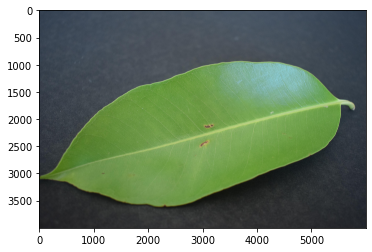

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

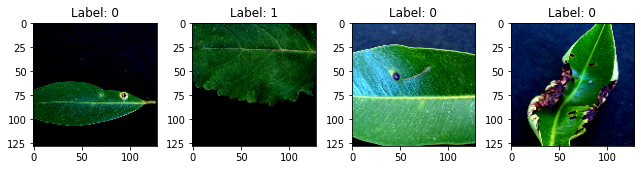

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:14] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:16] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2650701416073098 samples/sec                   batch loss = 0.5861504077911377 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2785219236214724 samples/sec                   batch loss = 0.5927735567092896 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2756944145575564 samples/sec                   batch loss = 0.7915350198745728 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2765663645034355 samples/sec                   batch loss = 0.560300350189209 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.273122697488937 samples/sec                   batch loss = 1.1880691051483154 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2754381910403465 samples/sec                   batch loss = 0.6495189666748047 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2741140077755115 samples/sec                   batch loss = 0.30627164244651794 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2753127353125802 samples/sec                   batch loss = 0.43877848982810974 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.2756682249940463 samples/sec                   batch loss = 1.3029767274856567 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2762125098860126 samples/sec                   batch loss = 0.5511511564254761 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2717012258414366 samples/sec                   batch loss = 0.5882559418678284 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2691899242580928 samples/sec                   batch loss = 0.6729505658149719 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.277334371409518 samples/sec                   batch loss = 0.27516648173332214 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2773216317956335 samples/sec                   batch loss = 1.2106225490570068 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2717099977616313 samples/sec                   batch loss = 0.6235308647155762 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.257297337886834 samples/sec                   batch loss = 0.6036351919174194 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2753854462126777 samples/sec                   batch loss = 0.5699877738952637 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.279281946008546 samples/sec                   batch loss = 0.6440664529800415 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.2828337008774953 samples/sec                   batch loss = 0.6390193700790405 | accuracy = 0.6105263157894737


Epoch[1] Batch[100] Speed: 1.2764426290286417 samples/sec                   batch loss = 0.524268388748169 | accuracy = 0.6025


Epoch[1] Batch[105] Speed: 1.2831848579252643 samples/sec                   batch loss = 0.6906031966209412 | accuracy = 0.6095238095238096


Epoch[1] Batch[110] Speed: 1.277649247036626 samples/sec                   batch loss = 0.3836379945278168 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.280597642194924 samples/sec                   batch loss = 0.6639740467071533 | accuracy = 0.6173913043478261


Epoch[1] Batch[120] Speed: 1.280812820513995 samples/sec                   batch loss = 0.5937142372131348 | accuracy = 0.61875


Epoch[1] Batch[125] Speed: 1.275588401958528 samples/sec                   batch loss = 0.7040757536888123 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.2743554701860715 samples/sec                   batch loss = 0.4354993402957916 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.278141082500023 samples/sec                   batch loss = 0.8799174427986145 | accuracy = 0.6203703703703703


Epoch[1] Batch[140] Speed: 1.2775176165637008 samples/sec                   batch loss = 0.8244082927703857 | accuracy = 0.625


Epoch[1] Batch[145] Speed: 1.278239923542778 samples/sec                   batch loss = 0.4462883174419403 | accuracy = 0.6275862068965518


Epoch[1] Batch[150] Speed: 1.2773568365386505 samples/sec                   batch loss = 0.9876989126205444 | accuracy = 0.6266666666666667


Epoch[1] Batch[155] Speed: 1.2719140031327028 samples/sec                   batch loss = 0.44059160351753235 | accuracy = 0.6306451612903226


Epoch[1] Batch[160] Speed: 1.2796922615044966 samples/sec                   batch loss = 0.569607138633728 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2784525566245386 samples/sec                   batch loss = 0.8052297830581665 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.2744775427216435 samples/sec                   batch loss = 0.9607121348381042 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.2843812538330175 samples/sec                   batch loss = 0.5683300495147705 | accuracy = 0.63


Epoch[1] Batch[180] Speed: 1.2798929776990082 samples/sec                   batch loss = 0.6248812675476074 | accuracy = 0.6263888888888889


Epoch[1] Batch[185] Speed: 1.2830101874759874 samples/sec                   batch loss = 1.8577088117599487 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.2829193383931667 samples/sec                   batch loss = 0.9055962562561035 | accuracy = 0.6276315789473684


Epoch[1] Batch[195] Speed: 1.2818255491276218 samples/sec                   batch loss = 0.34648314118385315 | accuracy = 0.6307692307692307


Epoch[1] Batch[200] Speed: 1.2756486320237896 samples/sec                   batch loss = 0.4023136794567108 | accuracy = 0.635


Epoch[1] Batch[205] Speed: 1.2751260516975367 samples/sec                   batch loss = 0.3882543742656708 | accuracy = 0.6390243902439025


Epoch[1] Batch[210] Speed: 1.2752651384002496 samples/sec                   batch loss = 0.5755236148834229 | accuracy = 0.6369047619047619


Epoch[1] Batch[215] Speed: 1.2762424109739763 samples/sec                   batch loss = 0.23297119140625 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.2761518382830581 samples/sec                   batch loss = 0.21879777312278748 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.283369981997711 samples/sec                   batch loss = 0.832945704460144 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2753716789793144 samples/sec                   batch loss = 0.6554161906242371 | accuracy = 0.6467391304347826


Epoch[1] Batch[235] Speed: 1.2750831202585429 samples/sec                   batch loss = 0.5621795058250427 | accuracy = 0.6468085106382979


Epoch[1] Batch[240] Speed: 1.2766756485074189 samples/sec                   batch loss = 0.3866194486618042 | accuracy = 0.6479166666666667


Epoch[1] Batch[245] Speed: 1.2726429214899342 samples/sec                   batch loss = 0.688399612903595 | accuracy = 0.6479591836734694


Epoch[1] Batch[250] Speed: 1.2797495607282052 samples/sec                   batch loss = 0.6921738386154175 | accuracy = 0.649


Epoch[1] Batch[255] Speed: 1.2730722692355732 samples/sec                   batch loss = 0.4001031517982483 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.2797411656318596 samples/sec                   batch loss = 0.42078933119773865 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2721351471319056 samples/sec                   batch loss = 0.3290410041809082 | accuracy = 0.6490566037735849


Epoch[1] Batch[270] Speed: 1.2769608464352 samples/sec                   batch loss = 0.5562595129013062 | accuracy = 0.65


Epoch[1] Batch[275] Speed: 1.2763492120126674 samples/sec                   batch loss = 0.4943391680717468 | accuracy = 0.65


Epoch[1] Batch[280] Speed: 1.2744052257157794 samples/sec                   batch loss = 0.6131194829940796 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.274344919415451 samples/sec                   batch loss = 1.1748682260513306 | accuracy = 0.6482456140350877


Epoch[1] Batch[290] Speed: 1.277279038595911 samples/sec                   batch loss = 0.8720743656158447 | accuracy = 0.6491379310344828


Epoch[1] Batch[295] Speed: 1.2707050030837508 samples/sec                   batch loss = 0.6630861759185791 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.2728557243401901 samples/sec                   batch loss = 0.579478919506073 | accuracy = 0.65


Epoch[1] Batch[305] Speed: 1.2793139421311006 samples/sec                   batch loss = 0.7747818231582642 | accuracy = 0.65


Epoch[1] Batch[310] Speed: 1.2743470489147148 samples/sec                   batch loss = 0.7426215410232544 | accuracy = 0.6491935483870968


Epoch[1] Batch[315] Speed: 1.276454379954119 samples/sec                   batch loss = 0.6189954876899719 | accuracy = 0.6515873015873016


Epoch[1] Batch[320] Speed: 1.2788693589682218 samples/sec                   batch loss = 1.4732941389083862 | accuracy = 0.65390625


Epoch[1] Batch[325] Speed: 1.2738376238970897 samples/sec                   batch loss = 0.17732855677604675 | accuracy = 0.6546153846153846


Epoch[1] Batch[330] Speed: 1.2729724871674386 samples/sec                   batch loss = 0.30801326036453247 | accuracy = 0.656060606060606


Epoch[1] Batch[335] Speed: 1.2691631369931895 samples/sec                   batch loss = 0.33852145075798035 | accuracy = 0.658955223880597


Epoch[1] Batch[340] Speed: 1.2700150262107075 samples/sec                   batch loss = 2.1298129558563232 | accuracy = 0.6595588235294118


Epoch[1] Batch[345] Speed: 1.2674440152701731 samples/sec                   batch loss = 0.23262356221675873 | accuracy = 0.6615942028985508


Epoch[1] Batch[350] Speed: 1.2780040936434265 samples/sec                   batch loss = 0.40725383162498474 | accuracy = 0.66


Epoch[1] Batch[355] Speed: 1.2789092310871641 samples/sec                   batch loss = 0.5538891553878784 | accuracy = 0.6584507042253521


Epoch[1] Batch[360] Speed: 1.2736492446872119 samples/sec                   batch loss = 0.34488868713378906 | accuracy = 0.6597222222222222


Epoch[1] Batch[365] Speed: 1.2729481477389926 samples/sec                   batch loss = 0.4672902524471283 | accuracy = 0.6602739726027397


Epoch[1] Batch[370] Speed: 1.2765400419973756 samples/sec                   batch loss = 0.42684420943260193 | accuracy = 0.6628378378378378


Epoch[1] Batch[375] Speed: 1.2767522070246418 samples/sec                   batch loss = 1.1400192975997925 | accuracy = 0.662


Epoch[1] Batch[380] Speed: 1.2804736126765637 samples/sec                   batch loss = 0.31473419070243835 | accuracy = 0.6592105263157895


Epoch[1] Batch[385] Speed: 1.274284425250209 samples/sec                   batch loss = 0.8595946431159973 | accuracy = 0.6584415584415585


Epoch[1] Batch[390] Speed: 1.2743748298526036 samples/sec                   batch loss = 0.5254800915718079 | accuracy = 0.658974358974359


Epoch[1] Batch[395] Speed: 1.2773623800037535 samples/sec                   batch loss = 0.5265407562255859 | accuracy = 0.6582278481012658


Epoch[1] Batch[400] Speed: 1.2765356712066276 samples/sec                   batch loss = 0.21346908807754517 | accuracy = 0.660625


Epoch[1] Batch[405] Speed: 1.2775207294620265 samples/sec                   batch loss = 0.4465557932853699 | accuracy = 0.6623456790123456


Epoch[1] Batch[410] Speed: 1.2771710124203797 samples/sec                   batch loss = 0.7590362429618835 | accuracy = 0.6634146341463415


Epoch[1] Batch[415] Speed: 1.2740703704271852 samples/sec                   batch loss = 0.3928171396255493 | accuracy = 0.6644578313253012


Epoch[1] Batch[420] Speed: 1.2799768558872342 samples/sec                   batch loss = 0.5615391731262207 | accuracy = 0.6642857142857143


Epoch[1] Batch[425] Speed: 1.275894945849501 samples/sec                   batch loss = 1.4772765636444092 | accuracy = 0.6641176470588235


Epoch[1] Batch[430] Speed: 1.275867777783608 samples/sec                   batch loss = 0.45890623331069946 | accuracy = 0.6656976744186046


Epoch[1] Batch[435] Speed: 1.275321847957626 samples/sec                   batch loss = 1.1952319145202637 | accuracy = 0.6660919540229885


Epoch[1] Batch[440] Speed: 1.2771420400104108 samples/sec                   batch loss = 0.5931780338287354 | accuracy = 0.6676136363636364


Epoch[1] Batch[445] Speed: 1.273438496224896 samples/sec                   batch loss = 0.36262333393096924 | accuracy = 0.6668539325842696


Epoch[1] Batch[450] Speed: 1.2752983880077127 samples/sec                   batch loss = 0.6197302341461182 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.2758077210581988 samples/sec                   batch loss = 0.8065218925476074 | accuracy = 0.6681318681318681


Epoch[1] Batch[460] Speed: 1.2792282975655478 samples/sec                   batch loss = 0.5119072794914246 | accuracy = 0.6695652173913044


Epoch[1] Batch[465] Speed: 1.271629609086369 samples/sec                   batch loss = 1.1317648887634277 | accuracy = 0.6682795698924732


Epoch[1] Batch[470] Speed: 1.2710120927550366 samples/sec                   batch loss = 0.7643091678619385 | accuracy = 0.6680851063829787


Epoch[1] Batch[475] Speed: 1.2798523607811354 samples/sec                   batch loss = 0.8178303837776184 | accuracy = 0.6689473684210526


Epoch[1] Batch[480] Speed: 1.272959544657072 samples/sec                   batch loss = 0.7087621092796326 | accuracy = 0.6682291666666667


Epoch[1] Batch[485] Speed: 1.2744079362453298 samples/sec                   batch loss = 1.0583813190460205 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.2700491563331882 samples/sec                   batch loss = 0.7144073247909546 | accuracy = 0.6673469387755102


Epoch[1] Batch[495] Speed: 1.2697067845303467 samples/sec                   batch loss = 0.536678671836853 | accuracy = 0.6671717171717172


Epoch[1] Batch[500] Speed: 1.271270008681381 samples/sec                   batch loss = 0.6448425054550171 | accuracy = 0.668


Epoch[1] Batch[505] Speed: 1.2700758848647922 samples/sec                   batch loss = 0.39558953046798706 | accuracy = 0.6693069306930693


Epoch[1] Batch[510] Speed: 1.2749399071571181 samples/sec                   batch loss = 0.3473151624202728 | accuracy = 0.6705882352941176


Epoch[1] Batch[515] Speed: 1.2676890862721701 samples/sec                   batch loss = 0.5608670115470886 | accuracy = 0.6713592233009709


Epoch[1] Batch[520] Speed: 1.2731935163206403 samples/sec                   batch loss = 0.27753108739852905 | accuracy = 0.6721153846153847


Epoch[1] Batch[525] Speed: 1.2725611600098576 samples/sec                   batch loss = 0.48321986198425293 | accuracy = 0.6704761904761904


Epoch[1] Batch[530] Speed: 1.2698840989275193 samples/sec                   batch loss = 0.6804173588752747 | accuracy = 0.6683962264150943


Epoch[1] Batch[535] Speed: 1.2719774548177847 samples/sec                   batch loss = 0.5858309268951416 | accuracy = 0.6691588785046729


Epoch[1] Batch[540] Speed: 1.2703964264285093 samples/sec                   batch loss = 0.5164360404014587 | accuracy = 0.6694444444444444


Epoch[1] Batch[545] Speed: 1.2703764179011352 samples/sec                   batch loss = 0.38505446910858154 | accuracy = 0.6706422018348623


Epoch[1] Batch[550] Speed: 1.274737545122788 samples/sec                   batch loss = 0.5240950584411621 | accuracy = 0.6731818181818182


Epoch[1] Batch[555] Speed: 1.2700380037533656 samples/sec                   batch loss = 1.0220576524734497 | accuracy = 0.6720720720720721


Epoch[1] Batch[560] Speed: 1.2709384354651574 samples/sec                   batch loss = 0.48339027166366577 | accuracy = 0.6714285714285714


Epoch[1] Batch[565] Speed: 1.2695849516353916 samples/sec                   batch loss = 0.4737951159477234 | accuracy = 0.6721238938053097


Epoch[1] Batch[570] Speed: 1.266072640708877 samples/sec                   batch loss = 0.4466768801212311 | accuracy = 0.6728070175438596


Epoch[1] Batch[575] Speed: 1.2724241100218205 samples/sec                   batch loss = 0.16453620791435242 | accuracy = 0.6747826086956522


Epoch[1] Batch[580] Speed: 1.27254571628186 samples/sec                   batch loss = 0.8041384220123291 | accuracy = 0.6754310344827587


Epoch[1] Batch[585] Speed: 1.2754455601503543 samples/sec                   batch loss = 0.43468785285949707 | accuracy = 0.6760683760683761


Epoch[1] Batch[590] Speed: 1.2698912117574805 samples/sec                   batch loss = 0.45700809359550476 | accuracy = 0.6758474576271186


Epoch[1] Batch[595] Speed: 1.2766262012493077 samples/sec                   batch loss = 0.4564911425113678 | accuracy = 0.676890756302521


Epoch[1] Batch[600] Speed: 1.2721848258974884 samples/sec                   batch loss = 0.41652727127075195 | accuracy = 0.6775


Epoch[1] Batch[605] Speed: 1.2725208140600022 samples/sec                   batch loss = 0.4395553469657898 | accuracy = 0.6772727272727272


Epoch[1] Batch[610] Speed: 1.2731194127684258 samples/sec                   batch loss = 0.33905065059661865 | accuracy = 0.6778688524590164


Epoch[1] Batch[615] Speed: 1.2713942848542796 samples/sec                   batch loss = 0.3975781798362732 | accuracy = 0.6780487804878049


Epoch[1] Batch[620] Speed: 1.268902524249287 samples/sec                   batch loss = 0.4406713843345642 | accuracy = 0.677016129032258


Epoch[1] Batch[625] Speed: 1.2732596081215872 samples/sec                   batch loss = 0.7816981077194214 | accuracy = 0.6784


Epoch[1] Batch[630] Speed: 1.269258673811605 samples/sec                   batch loss = 0.4756458103656769 | accuracy = 0.6793650793650794


Epoch[1] Batch[635] Speed: 1.2689170159225593 samples/sec                   batch loss = 0.8359885811805725 | accuracy = 0.6795275590551181


Epoch[1] Batch[640] Speed: 1.269308992450822 samples/sec                   batch loss = 0.594919741153717 | accuracy = 0.6796875


Epoch[1] Batch[645] Speed: 1.271806207641276 samples/sec                   batch loss = 0.6592504978179932 | accuracy = 0.6802325581395349


Epoch[1] Batch[650] Speed: 1.2701910804010685 samples/sec                   batch loss = 0.8013936281204224 | accuracy = 0.6796153846153846


Epoch[1] Batch[655] Speed: 1.2745375711016362 samples/sec                   batch loss = 0.3522149622440338 | accuracy = 0.6812977099236641


Epoch[1] Batch[660] Speed: 1.2711859192873631 samples/sec                   batch loss = 0.2925111949443817 | accuracy = 0.6821969696969697


Epoch[1] Batch[665] Speed: 1.2772245856743487 samples/sec                   batch loss = 0.8152978420257568 | accuracy = 0.6815789473684211


Epoch[1] Batch[670] Speed: 1.2726496791070736 samples/sec                   batch loss = 0.3558577001094818 | accuracy = 0.6824626865671641


Epoch[1] Batch[675] Speed: 1.2691205101288916 samples/sec                   batch loss = 0.27144864201545715 | accuracy = 0.6825925925925926


Epoch[1] Batch[680] Speed: 1.2735616499292288 samples/sec                   batch loss = 0.33598577976226807 | accuracy = 0.6823529411764706


Epoch[1] Batch[685] Speed: 1.2724492014738893 samples/sec                   batch loss = 0.3013322353363037 | accuracy = 0.6832116788321168


Epoch[1] Batch[690] Speed: 1.2860084435328298 samples/sec                   batch loss = 0.7355807423591614 | accuracy = 0.683695652173913


Epoch[1] Batch[695] Speed: 1.277296445062609 samples/sec                   batch loss = 0.5725345611572266 | accuracy = 0.6845323741007194


Epoch[1] Batch[700] Speed: 1.27809239795066 samples/sec                   batch loss = 0.6449242234230042 | accuracy = 0.6842857142857143


Epoch[1] Batch[705] Speed: 1.2701283837447765 samples/sec                   batch loss = 0.5374870300292969 | accuracy = 0.6854609929078014


Epoch[1] Batch[710] Speed: 1.2739489562857451 samples/sec                   batch loss = 0.963580846786499 | accuracy = 0.6862676056338028


Epoch[1] Batch[715] Speed: 1.275160263243441 samples/sec                   batch loss = 0.4490140378475189 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2704731957612163 samples/sec                   batch loss = 0.33526748418807983 | accuracy = 0.6875


Epoch[1] Batch[725] Speed: 1.2721548252468338 samples/sec                   batch loss = 0.6321381330490112 | accuracy = 0.6865517241379311


Epoch[1] Batch[730] Speed: 1.2730934254301407 samples/sec                   batch loss = 0.27299973368644714 | accuracy = 0.6873287671232877


Epoch[1] Batch[735] Speed: 1.2672847077030385 samples/sec                   batch loss = 0.4851296842098236 | accuracy = 0.6870748299319728


Epoch[1] Batch[740] Speed: 1.268116055955118 samples/sec                   batch loss = 0.7720058560371399 | accuracy = 0.6868243243243243


Epoch[1] Batch[745] Speed: 1.2697000581298241 samples/sec                   batch loss = 0.4276077151298523 | accuracy = 0.6889261744966443


Epoch[1] Batch[750] Speed: 1.2722647059113479 samples/sec                   batch loss = 1.1289297342300415 | accuracy = 0.6893333333333334


Epoch[1] Batch[755] Speed: 1.2638518320982743 samples/sec                   batch loss = 0.4748515784740448 | accuracy = 0.6903973509933775


Epoch[1] Batch[760] Speed: 1.2658919953074244 samples/sec                   batch loss = 0.5526402592658997 | accuracy = 0.6901315789473684


Epoch[1] Batch[765] Speed: 1.2693237815117657 samples/sec                   batch loss = 0.23102429509162903 | accuracy = 0.6901960784313725


Epoch[1] Batch[770] Speed: 1.2673156278543882 samples/sec                   batch loss = 0.4223593771457672 | accuracy = 0.6902597402597402


Epoch[1] Batch[775] Speed: 1.2691170540221461 samples/sec                   batch loss = 1.108094573020935 | accuracy = 0.6912903225806452


Epoch[1] Batch[780] Speed: 1.2727105974380286 samples/sec                   batch loss = 0.31018829345703125 | accuracy = 0.6916666666666667


Epoch[1] Batch[785] Speed: 1.2776185016454924 samples/sec                   batch loss = 0.7361831665039062 | accuracy = 0.6917197452229299


[Epoch 1] training: accuracy=0.6906725888324873
[Epoch 1] time cost: 646.4847979545593
[Epoch 1] validation: validation accuracy=0.7511111111111111


Epoch[2] Batch[5] Speed: 1.2651945442515269 samples/sec                   batch loss = 0.862884521484375 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2678759938475894 samples/sec                   batch loss = 0.23467865586280823 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2712115398487143 samples/sec                   batch loss = 0.41760167479515076 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2752272379011171 samples/sec                   batch loss = 0.4517916440963745 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.27787414202371 samples/sec                   batch loss = 0.31465980410575867 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2703591995287835 samples/sec                   batch loss = 0.23508021235466003 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2719770690741299 samples/sec                   batch loss = 0.6151773929595947 | accuracy = 0.7642857142857142


Epoch[2] Batch[40] Speed: 1.2637022783783451 samples/sec                   batch loss = 0.6725204586982727 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2672411540122694 samples/sec                   batch loss = 0.19792674481868744 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2671331920575177 samples/sec                   batch loss = 0.5756666660308838 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.274353631048345 samples/sec                   batch loss = 1.5314284563064575 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.2732296533850116 samples/sec                   batch loss = 0.8632952570915222 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2658347841668947 samples/sec                   batch loss = 0.3199484944343567 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.272431926868074 samples/sec                   batch loss = 0.4762568771839142 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2753075973892751 samples/sec                   batch loss = 0.4184742271900177 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.2750797285073514 samples/sec                   batch loss = 0.6758005023002625 | accuracy = 0.725


Epoch[2] Batch[85] Speed: 1.2813010280901223 samples/sec                   batch loss = 0.8638263940811157 | accuracy = 0.7176470588235294


Epoch[2] Batch[90] Speed: 1.2794521876772122 samples/sec                   batch loss = 0.5268758535385132 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.277937119021282 samples/sec                   batch loss = 0.27831459045410156 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2670972088270458 samples/sec                   batch loss = 0.6611974835395813 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2622287224998383 samples/sec                   batch loss = 1.3186479806900024 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.2709718449687337 samples/sec                   batch loss = 0.2180558443069458 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2734006075690498 samples/sec                   batch loss = 0.8226016163825989 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.2723176753644037 samples/sec                   batch loss = 0.2913210988044739 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.271550387027003 samples/sec                   batch loss = 0.2863732874393463 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.26936104379069 samples/sec                   batch loss = 0.1346234679222107 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.271251128536254 samples/sec                   batch loss = 0.33390161395072937 | accuracy = 0.7555555555555555


Epoch[2] Batch[140] Speed: 1.2669988395748037 samples/sec                   batch loss = 0.5796820521354675 | accuracy = 0.7553571428571428


Epoch[2] Batch[145] Speed: 1.2667801471218931 samples/sec                   batch loss = 0.2950200140476227 | accuracy = 0.7517241379310344


Epoch[2] Batch[150] Speed: 1.2759395816125 samples/sec                   batch loss = 0.8786633014678955 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2697073610822789 samples/sec                   batch loss = 0.7233930230140686 | accuracy = 0.7516129032258064


Epoch[2] Batch[160] Speed: 1.2723102458673579 samples/sec                   batch loss = 0.33176299929618835 | accuracy = 0.75


Epoch[2] Batch[165] Speed: 1.269326086331523 samples/sec                   batch loss = 0.2704920172691345 | accuracy = 0.7484848484848485


Epoch[2] Batch[170] Speed: 1.2811907551406192 samples/sec                   batch loss = 0.6578992009162903 | accuracy = 0.7455882352941177


Epoch[2] Batch[175] Speed: 1.267076634227999 samples/sec                   batch loss = 1.1471906900405884 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.2688473437551877 samples/sec                   batch loss = 0.27211421728134155 | accuracy = 0.7444444444444445


Epoch[2] Batch[185] Speed: 1.2641593328109586 samples/sec                   batch loss = 0.4454619288444519 | accuracy = 0.7472972972972973


Epoch[2] Batch[190] Speed: 1.2657875100815807 samples/sec                   batch loss = 0.5986915230751038 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.2717936744676133 samples/sec                   batch loss = 0.45431017875671387 | accuracy = 0.7461538461538462


Epoch[2] Batch[200] Speed: 1.27331652600433 samples/sec                   batch loss = 0.23534917831420898 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.279686307364993 samples/sec                   batch loss = 0.4385586977005005 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2774549727094755 samples/sec                   batch loss = 0.28676697611808777 | accuracy = 0.7523809523809524


Epoch[2] Batch[215] Speed: 1.2695669861441379 samples/sec                   batch loss = 0.41581717133522034 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2794403814920736 samples/sec                   batch loss = 0.9127364754676819 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.277344096476648 samples/sec                   batch loss = 0.21085886657238007 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2714957469064103 samples/sec                   batch loss = 0.3137625753879547 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.2690426562883403 samples/sec                   batch loss = 0.9177595376968384 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.274674495692549 samples/sec                   batch loss = 0.499874472618103 | accuracy = 0.7416666666666667


Epoch[2] Batch[245] Speed: 1.2691039977887602 samples/sec                   batch loss = 0.9094741940498352 | accuracy = 0.7387755102040816


Epoch[2] Batch[250] Speed: 1.2758237291641397 samples/sec                   batch loss = 0.38343289494514465 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2697107243123202 samples/sec                   batch loss = 0.4291621446609497 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.274698320089745 samples/sec                   batch loss = 0.27703073620796204 | accuracy = 0.7375


Epoch[2] Batch[265] Speed: 1.2711502833817179 samples/sec                   batch loss = 0.4442603886127472 | accuracy = 0.7358490566037735


Epoch[2] Batch[270] Speed: 1.270784504854513 samples/sec                   batch loss = 0.5359200835227966 | accuracy = 0.7379629629629629


Epoch[2] Batch[275] Speed: 1.2688498387695832 samples/sec                   batch loss = 0.7064590454101562 | accuracy = 0.7381818181818182


Epoch[2] Batch[280] Speed: 1.2756442673351605 samples/sec                   batch loss = 0.3038029670715332 | accuracy = 0.7383928571428572


Epoch[2] Batch[285] Speed: 1.2691803229578655 samples/sec                   batch loss = 0.44257447123527527 | accuracy = 0.7403508771929824


Epoch[2] Batch[290] Speed: 1.270683156276641 samples/sec                   batch loss = 0.6148146390914917 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2710149814501779 samples/sec                   batch loss = 0.48256295919418335 | accuracy = 0.7432203389830508


Epoch[2] Batch[300] Speed: 1.2747800658482253 samples/sec                   batch loss = 0.48384714126586914 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.2682217887782148 samples/sec                   batch loss = 0.319258451461792 | accuracy = 0.7442622950819672


Epoch[2] Batch[310] Speed: 1.2745392171207377 samples/sec                   batch loss = 0.4381905496120453 | accuracy = 0.7467741935483871


Epoch[2] Batch[315] Speed: 1.2757549456634396 samples/sec                   batch loss = 0.26696741580963135 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.2698242197478322 samples/sec                   batch loss = 0.3129950165748596 | accuracy = 0.74765625


Epoch[2] Batch[325] Speed: 1.2649763787910444 samples/sec                   batch loss = 0.5685938596725464 | accuracy = 0.7461538461538462


Epoch[2] Batch[330] Speed: 1.2640858009135327 samples/sec                   batch loss = 0.2919764816761017 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.2657702248835137 samples/sec                   batch loss = 0.39667242765426636 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.2677888081616226 samples/sec                   batch loss = 0.34246158599853516 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2665501518942257 samples/sec                   batch loss = 0.5534030199050903 | accuracy = 0.7485507246376811


Epoch[2] Batch[350] Speed: 1.274324883111801 samples/sec                   batch loss = 0.3392229378223419 | accuracy = 0.7514285714285714


Epoch[2] Batch[355] Speed: 1.264362923631865 samples/sec                   batch loss = 0.39999884366989136 | accuracy = 0.752112676056338


Epoch[2] Batch[360] Speed: 1.2743220761437324 samples/sec                   batch loss = 0.36784011125564575 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.270804237464405 samples/sec                   batch loss = 0.8487960696220398 | accuracy = 0.7506849315068493


Epoch[2] Batch[370] Speed: 1.2705443936596736 samples/sec                   batch loss = 0.6129980683326721 | accuracy = 0.75


Epoch[2] Batch[375] Speed: 1.2725984195467144 samples/sec                   batch loss = 0.8225595355033875 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.2717077806714732 samples/sec                   batch loss = 0.19430892169475555 | accuracy = 0.7513157894736842


Epoch[2] Batch[385] Speed: 1.2672322521978006 samples/sec                   batch loss = 0.3489707410335541 | accuracy = 0.7532467532467533


Epoch[2] Batch[390] Speed: 1.2654203250271379 samples/sec                   batch loss = 0.0769684836268425 | accuracy = 0.7519230769230769


Epoch[2] Batch[395] Speed: 1.2643632094863173 samples/sec                   batch loss = 0.19929173588752747 | accuracy = 0.7512658227848101


Epoch[2] Batch[400] Speed: 1.2659962111908338 samples/sec                   batch loss = 0.6140064001083374 | accuracy = 0.751875


Epoch[2] Batch[405] Speed: 1.266283060623436 samples/sec                   batch loss = 0.9739537239074707 | accuracy = 0.7518518518518519


Epoch[2] Batch[410] Speed: 1.2719006964394897 samples/sec                   batch loss = 0.18171411752700806 | accuracy = 0.7518292682926829


Epoch[2] Batch[415] Speed: 1.2715370879409253 samples/sec                   batch loss = 1.743228793144226 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.2754795949079696 samples/sec                   batch loss = 0.3622508645057678 | accuracy = 0.75


Epoch[2] Batch[425] Speed: 1.266683357246767 samples/sec                   batch loss = 0.32506033778190613 | accuracy = 0.75


Epoch[2] Batch[430] Speed: 1.266962385589151 samples/sec                   batch loss = 0.6319330334663391 | accuracy = 0.7488372093023256


Epoch[2] Batch[435] Speed: 1.27009155715293 samples/sec                   batch loss = 0.43371129035949707 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.2736281667020173 samples/sec                   batch loss = 0.43829870223999023 | accuracy = 0.7494318181818181


Epoch[2] Batch[445] Speed: 1.2680804961118721 samples/sec                   batch loss = 0.45625773072242737 | accuracy = 0.749438202247191


Epoch[2] Batch[450] Speed: 1.2703662214901976 samples/sec                   batch loss = 0.5034431219100952 | accuracy = 0.7488888888888889


Epoch[2] Batch[455] Speed: 1.2699608063515238 samples/sec                   batch loss = 1.0239001512527466 | accuracy = 0.7472527472527473


Epoch[2] Batch[460] Speed: 1.2722753187453406 samples/sec                   batch loss = 0.30352652072906494 | accuracy = 0.7467391304347826


Epoch[2] Batch[465] Speed: 1.2692627068379068 samples/sec                   batch loss = 0.49342861771583557 | accuracy = 0.7478494623655914


Epoch[2] Batch[470] Speed: 1.271727156372975 samples/sec                   batch loss = 0.384573370218277 | accuracy = 0.7489361702127659


Epoch[2] Batch[475] Speed: 1.272385316724458 samples/sec                   batch loss = 0.3251088857650757 | accuracy = 0.7505263157894737


Epoch[2] Batch[480] Speed: 1.273224918733066 samples/sec                   batch loss = 0.38892945647239685 | accuracy = 0.7515625


Epoch[2] Batch[485] Speed: 1.271940231633126 samples/sec                   batch loss = 0.3797549605369568 | accuracy = 0.7510309278350515


Epoch[2] Batch[490] Speed: 1.2744821898781573 samples/sec                   batch loss = 0.12338592112064362 | accuracy = 0.753061224489796


Epoch[2] Batch[495] Speed: 1.273143179069756 samples/sec                   batch loss = 0.3630821108818054 | accuracy = 0.753030303030303


Epoch[2] Batch[500] Speed: 1.2735648402553352 samples/sec                   batch loss = 1.1345477104187012 | accuracy = 0.751


Epoch[2] Batch[505] Speed: 1.2697727070271634 samples/sec                   batch loss = 0.3758997321128845 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.2692948759413953 samples/sec                   batch loss = 0.5724244713783264 | accuracy = 0.7509803921568627


Epoch[2] Batch[515] Speed: 1.2751642369414207 samples/sec                   batch loss = 0.8439237475395203 | accuracy = 0.7504854368932039


Epoch[2] Batch[520] Speed: 1.2719701257283484 samples/sec                   batch loss = 0.8715328574180603 | accuracy = 0.7495192307692308


Epoch[2] Batch[525] Speed: 1.2717896253412249 samples/sec                   batch loss = 0.3213581442832947 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.2684387736108254 samples/sec                   batch loss = 0.6935785412788391 | accuracy = 0.7514150943396226


Epoch[2] Batch[535] Speed: 1.2673931741894173 samples/sec                   batch loss = 0.5781299471855164 | accuracy = 0.7509345794392523


Epoch[2] Batch[540] Speed: 1.2646930763524964 samples/sec                   batch loss = 0.17082031071186066 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2673286473168814 samples/sec                   batch loss = 0.41720908880233765 | accuracy = 0.751834862385321


Epoch[2] Batch[550] Speed: 1.2660545834026962 samples/sec                   batch loss = 0.40493345260620117 | accuracy = 0.7513636363636363


Epoch[2] Batch[555] Speed: 1.2714321505637594 samples/sec                   batch loss = 0.27030831575393677 | accuracy = 0.7509009009009009


Epoch[2] Batch[560] Speed: 1.2695264455669453 samples/sec                   batch loss = 0.35863399505615234 | accuracy = 0.75


Epoch[2] Batch[565] Speed: 1.2668825959968173 samples/sec                   batch loss = 0.7108277678489685 | accuracy = 0.7504424778761062


Epoch[2] Batch[570] Speed: 1.264789752990352 samples/sec                   batch loss = 1.6145447492599487 | accuracy = 0.750438596491228


Epoch[2] Batch[575] Speed: 1.2713131654047536 samples/sec                   batch loss = 0.3502507209777832 | accuracy = 0.7517391304347826


Epoch[2] Batch[580] Speed: 1.2688277678289106 samples/sec                   batch loss = 0.6428095698356628 | accuracy = 0.7512931034482758


Epoch[2] Batch[585] Speed: 1.2662128173170581 samples/sec                   batch loss = 0.6207298636436462 | accuracy = 0.7508547008547009


Epoch[2] Batch[590] Speed: 1.262683951197822 samples/sec                   batch loss = 0.4290437400341034 | accuracy = 0.7512711864406779


Epoch[2] Batch[595] Speed: 1.262817009881715 samples/sec                   batch loss = 0.5372239351272583 | accuracy = 0.7512605042016807


Epoch[2] Batch[600] Speed: 1.277164887271115 samples/sec                   batch loss = 0.9908734560012817 | accuracy = 0.7504166666666666


Epoch[2] Batch[605] Speed: 1.2704728109293937 samples/sec                   batch loss = 0.47041940689086914 | accuracy = 0.75


Epoch[2] Batch[610] Speed: 1.2730972896512114 samples/sec                   batch loss = 0.4168606102466583 | accuracy = 0.75


Epoch[2] Batch[615] Speed: 1.2711839929711106 samples/sec                   batch loss = 0.38487008213996887 | accuracy = 0.751219512195122


Epoch[2] Batch[620] Speed: 1.27407317628649 samples/sec                   batch loss = 0.4633253812789917 | accuracy = 0.7520161290322581


Epoch[2] Batch[625] Speed: 1.2666436700227723 samples/sec                   batch loss = 0.43336859345436096 | accuracy = 0.7524


Epoch[2] Batch[630] Speed: 1.2693078400709357 samples/sec                   batch loss = 0.5841395854949951 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2679967322881986 samples/sec                   batch loss = 0.534016489982605 | accuracy = 0.7519685039370079


Epoch[2] Batch[640] Speed: 1.2693887038041374 samples/sec                   batch loss = 0.37465813755989075 | accuracy = 0.751953125


Epoch[2] Batch[645] Speed: 1.2767715424171195 samples/sec                   batch loss = 1.029066562652588 | accuracy = 0.7527131782945736


Epoch[2] Batch[650] Speed: 1.2711041522983946 samples/sec                   batch loss = 0.6224527359008789 | accuracy = 0.7530769230769231


Epoch[2] Batch[655] Speed: 1.2709622166895638 samples/sec                   batch loss = 0.32641926407814026 | accuracy = 0.7538167938931297


Epoch[2] Batch[660] Speed: 1.272524771324698 samples/sec                   batch loss = 0.4646144211292267 | accuracy = 0.7537878787878788


Epoch[2] Batch[665] Speed: 1.271652741476561 samples/sec                   batch loss = 1.1652851104736328 | accuracy = 0.7537593984962406


Epoch[2] Batch[670] Speed: 1.274455759627232 samples/sec                   batch loss = 0.6141042709350586 | accuracy = 0.7533582089552239


Epoch[2] Batch[675] Speed: 1.2739349298482976 samples/sec                   batch loss = 0.5327464938163757 | accuracy = 0.752962962962963


Epoch[2] Batch[680] Speed: 1.2664104741524096 samples/sec                   batch loss = 0.36501654982566833 | accuracy = 0.7536764705882353


Epoch[2] Batch[685] Speed: 1.2727250796742042 samples/sec                   batch loss = 0.3132072389125824 | accuracy = 0.7536496350364964


Epoch[2] Batch[690] Speed: 1.270546702914306 samples/sec                   batch loss = 0.5114315748214722 | accuracy = 0.7532608695652174


Epoch[2] Batch[695] Speed: 1.2804565104120755 samples/sec                   batch loss = 0.443904846906662 | accuracy = 0.7535971223021583


Epoch[2] Batch[700] Speed: 1.2799831056917355 samples/sec                   batch loss = 0.47675180435180664 | accuracy = 0.7532142857142857


Epoch[2] Batch[705] Speed: 1.2711172497186296 samples/sec                   batch loss = 0.3638048470020294 | accuracy = 0.7531914893617021


Epoch[2] Batch[710] Speed: 1.273684247286367 samples/sec                   batch loss = 0.3861630856990814 | accuracy = 0.7531690140845071


Epoch[2] Batch[715] Speed: 1.2723415082327254 samples/sec                   batch loss = 0.29736751317977905 | accuracy = 0.7534965034965035


Epoch[2] Batch[720] Speed: 1.27367738198404 samples/sec                   batch loss = 0.3792063295841217 | accuracy = 0.7545138888888889


Epoch[2] Batch[725] Speed: 1.2662467433831592 samples/sec                   batch loss = 0.41935697197914124 | accuracy = 0.7555172413793103


Epoch[2] Batch[730] Speed: 1.271033276824332 samples/sec                   batch loss = 0.28663668036460876 | accuracy = 0.7558219178082192


Epoch[2] Batch[735] Speed: 1.272233929693999 samples/sec                   batch loss = 0.26783356070518494 | accuracy = 0.7554421768707483


Epoch[2] Batch[740] Speed: 1.2722407794442752 samples/sec                   batch loss = 0.3746437728404999 | accuracy = 0.7560810810810811


Epoch[2] Batch[745] Speed: 1.269749450787644 samples/sec                   batch loss = 0.5633201003074646 | accuracy = 0.7557046979865771


Epoch[2] Batch[750] Speed: 1.273796810120393 samples/sec                   batch loss = 0.4599083662033081 | accuracy = 0.756


Epoch[2] Batch[755] Speed: 1.2743034923912293 samples/sec                   batch loss = 0.3018606901168823 | accuracy = 0.7566225165562914


Epoch[2] Batch[760] Speed: 1.2700080081312168 samples/sec                   batch loss = 0.737496018409729 | accuracy = 0.7546052631578948


Epoch[2] Batch[765] Speed: 1.2659992681943832 samples/sec                   batch loss = 0.24280282855033875 | accuracy = 0.7552287581699346


Epoch[2] Batch[770] Speed: 1.2705875011303138 samples/sec                   batch loss = 0.6426106691360474 | accuracy = 0.7542207792207792


Epoch[2] Batch[775] Speed: 1.2694446037608733 samples/sec                   batch loss = 0.562228798866272 | accuracy = 0.7532258064516129


Epoch[2] Batch[780] Speed: 1.268849454920576 samples/sec                   batch loss = 0.29599419236183167 | accuracy = 0.7528846153846154


Epoch[2] Batch[785] Speed: 1.2699121662332 samples/sec                   batch loss = 0.41346457600593567 | accuracy = 0.7531847133757962


[Epoch 2] training: accuracy=0.7541243654822335
[Epoch 2] time cost: 637.8496091365814
[Epoch 2] validation: validation accuracy=0.7577777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)